# 2) Analyze source collection and target file

This notebook includes the code to analyze the collection of sounds compiled in the previous notebook and that will be later used as the source collection in our audio mosaicing code. The notebook also contains the code to analyze the target audio file that will be later reconstructed using sound chunks from the source collection.

The audio analysis carried out in this notebook uses the Pythonn bindings of the Essentia library which was introduced in the first session of AMPLAB. Please make sure you checked the [Essentia Python tutorial](https://essentia.upf.edu/documentation/essentia_python_tutorial.html) to get familiarized with using Essentia in Python. Also useful is to always have a browser tab opened with Essentia's [Algorithms Reference](https://essentia.upf.edu/documentation/algorithms_reference.html) documentation page.

In [1]:
import pandas as pd
import essentia
import essentia.standard as estd
import matplotlib.pyplot as plt
from IPython.display import display, Audio

In [2]:
# Define here our sound analysis function
# NOTE: remember that if you update this function and want to run a new analysis you'll need to re-run both 
# this cell and the cells below that carry out the audio analysis and that call the analysis function. 
# After analyzing the source collection or the target file, make sure to correct descriptors have been 
# extracted by checking the DataFrame contents. DataFrame contents can be printed on screen as a table 
# using 'display(data_frame_object)'

def analyze_sound(audio_path, frame_size=None, audio_id=None):
    """Analyze the audio file given in 'sound_path'.
    Use the parameter 'frame_size' to set the size of the chunks in which the audio will 
    be split for analysis. If no frame_size is given, the whole audio will be analyzed as 
    a single frame.
    Use the 'audio_id' parameter to pass a custom identifier for the audio that will be 
    included in the analysis results. This can be useful to later identify to which file an analysis belongs.
    """
    analysis_output = []  # Here we'll store the analysis results for each chunk (frame) of the audio file
    
    # Load audio file
    loader = estd.MonoLoader(filename=audio_path)
    audio = loader()
    
    # Some processing of frame_size parameter to avoid later problems
    if frame_size is None:
        frame_size = len(audio)  # If no frame_size is given use no frames (analyze all audio at once)
    if frame_size % 2 != 0:
        frame_size = frame_size + 1 # Make frame size even
    
    # Calculate the start and end samples for each equally-spaced audio frame
    frame_start_samples = range(0, len(audio), frame_size)
    frame_start_end_samples = zip(frame_start_samples[:-1], frame_start_samples[1:])
    
    # Iterate over audio frames and analyze each one
    for count, (fstart, fend) in enumerate(frame_start_end_samples):
        
        # Get corresponding audio chunk and initialize dictionary to sotre analysis results with some basic metadata
        frame = audio[fstart:fend]
        frame_output = {
            'freesound_id': audio_id,
            'id': '{0}_f{1}'.format(audio_id, count),
            'path': audio_path,
            'start_sample': fstart,
            'end_sample': fend,
        }
        
        # Extract loudness
        loudness_algo = estd.Loudness()
        loudness = loudness_algo(frame)
        frame_output['loudness'] = loudness / len(frame)  # Normnalize by length of frame

        # Extract MFCC coefficients
        w_algo = estd.Windowing(type = 'hann')
        spectrum_algo = estd.Spectrum()
        mfcc_algo = estd.MFCC()
        spec = spectrum_algo(w_algo(frame))
        _, mfcc_coeffs = mfcc_algo(spec)
        frame_output.update({'mfcc_{0}'.format(j): mfcc_coeffs[j] for j in range(0, len(mfcc_coeffs))})
        
        # Extract other features here and add to 'frame_output' dictionary
        # Extract MalBands coeficients
        melbands_algo = estd.MelBands()
        melbands = melbands_algo(spec)
        frame_output.update({'melbands{0}'.format(j): melbands[j] for j in range(0, len(melbands))})
        
        # Extract OnsetDetection of the frame
        onset_algo = estd.OnsetDetection()
        onsets = melbands_algo(spec)
        frame_output.update({'onsets{0}'.format(j): onsets[j] for j in range(0, len(onsets))})
        
        # Extract HPCP
        spectral_peaks_algo = estd.SpectralPeaks()
        HPCP_algo = estd.HPCP()
        HPCP = HPCP_algo(*spectral_peaks_algo(spec))
        frame_output.update({'HPCP{0}'.format(j): HPCP[j] for j in range(0, len(HPCP))})
        
        # Add frame analysis results to output
        analysis_output.append(frame_output)

    return analysis_output
    

## Analyze the target sound file

In [3]:
TARGET_SOUND_PATH = '262350__stereo-surgeon__grinder-drum-loop.wav'  # Filename of the target audio we'll reconstruct
DATAFRAME_TARGET_FILE_FILENAME = 'dataframe_target.csv'  # DataFrame file where to store the analysis results of the target audio

In [4]:
def compute_frame_size_from_beat(beat_positions, resolution=8):
    """
        Computes the average of the difference of consecutive
        values in an array, then it divides the value by 'resulution'.
        Since the beat_positions array contains the frame number where
        there are beats, the average of the difference of consecutive 
        values will give us an estimation of the tempo.
        beat_positions: array containing the output of the Essentia BeatTrackerDegara
        resolution: the resolution of the grid
    """
    output = [abs(beat_positions[i] - beat_positions[i + 1])
              for i in range(len(beat_positions) - 1)]
    return int((sum(output) / len(output))/resolution)

In [6]:
# Analyze the beat to determine the frame size
audio = estd.MonoLoader(filename=TARGET_SOUND_PATH)()
beat_tracker_algo = estd.BeatTrackerDegara()
beat_positions = beat_tracker_algo(audio)
beat_positions = [int(round(position * 44100)) for position in beat_positions]
frame_size = compute_frame_size_from_beat(beat_positions, 8)
frame_size

2538

I will now use this value to analyze both, the target and the source collection

Analyzing target sound 262350__stereo-surgeon__grinder-drum-loop.wav
Saved target dataframe with 513 entries! dataframe_target.csv


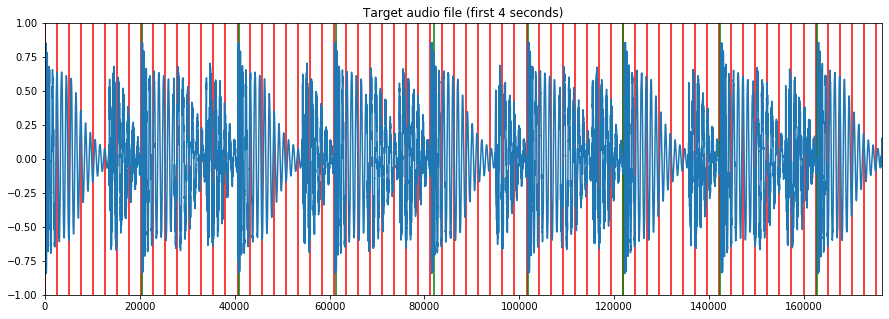

,HPCP0,HPCP1,HPCP10,HPCP11,HPCP2,HPCP3,HPCP4,HPCP5,HPCP6,HPCP7,...,onsets23,onsets3,onsets4,onsets5,onsets6,onsets7,onsets8,onsets9,path,start_sample
0,0.234311,0.047050,0.528633,0.199757,1.000000,0.997411,0.013083,0.590873,0.030052,0.500616,...,3.831887e-10,4.531599e-04,2.868509e-04,1.204855e-04,4.752380e-05,2.976988e-05,1.180040e-05,2.316342e-06,262350__stereo-surgeon__grinder-drum-loop.wav,0
1,0.245163,0.138836,0.683307,0.014016,0.084079,0.000890,0.080268,0.679511,0.203053,0.000483,...,1.942418e-11,5.154016e-06,4.302120e-06,2.382488e-06,1.155384e-06,2.308619e-07,5.725695e-08,9.086574e-09,262350__stereo-surgeon__grinder-drum-loop.wav,2538
2,0.056822,0.041682,0.171488,0.158803,0.109963,0.999212,0.002884,0.019518,0.003534,0.322837,...,3.829821e-12,1.288496e-06,3.321153e-07,1.335192e-07,2.601255e-08,5.280446e-09,2.247708e-09,6.160406e-10,262350__stereo-surgeon__grinder-drum-loop.wav,5076
3,0.047247,0.049305,0.003103,0.034113,0.014564,0.013251,0.007089,0.967521,0.010308,0.072359,...,1.952722e-12,1.128026e-07,2.204230e-08,8.260732e-09,2.960298e-09,9.794988e-10,1.865161e-10,8.114028e-11,262350__stereo-surgeon__grinder-drum-loop.wav,7614
4,0.157474,0.068725,0.051230,0.049573,0.180073,0.024084,0.917155,0.031812,0.036386,0.090190,...,1.284069e-12,3.555182e-09,6.325358e-10,3.853405e-10,2.503500e-10,1.656550e-10,3.524746e-11,1.217122e-11,262350__stereo-surgeon__grinder-drum-loop.wav,10152
5,0.001892,0.926257,0.402628,0.177348,0.741282,0.796825,0.093074,0.026923,0.144172,0.130046,...,4.655965e-08,2.005634e-03,9.309864e-04,4.496662e-04,1.995134e-04,1.489499e-04,1.035176e-04,2.664666e-05,262350__stereo-surgeon__grinder-drum-loop.wav,12690
6,0.914818,0.531979,0.081287,0.864582,0.168359,0.093172,0.245990,0.176472,0.129424,0.512446,...,5.246522e-10,1.957823e-04,4.748712e-04,3.641201e-04,1.077091e-04,9.840026e-05,8.951280e-05,9.449737e-06,262350__stereo-surgeon__grinder-drum-loop.wav,15228
7,0.867925,0.030805,0.014767,0.273330,0.003597,0.184596,0.202067,0.222481,0.098652,0.034210,...,1.160674e-12,8.236709e-05,1.469985e-04,1.727580e-04,3.081850e-05,2.173163e-05,8.222346e-06,1.652209e-06,262350__stereo-surgeon__grinder-drum-loop.wav,17766
8,0.405940,0.109353,0.733432,0.016605,0.005194,1.000000,0.015090,0.415213,0.022274,0.142212,...,1.052824e-09,4.766328e-04,2.700502e-04,1.325736e-04,6.184439e-05,2.661129e-05,1.158653e-05,2.886528e-06,262350__stereo-surgeon__grinder-drum-loop.wav,20304
9,0.221440,0.095028,0.387641,0.007840,0.063721,0.002728,0.505168,0.910327,0.297077,0.023645,...,4.385058e-11,7.701794e-06,4.143039e-06,2.612357e-06,1.650409e-06,3.207354e-07,4.014709e-08,1.507749e-08,262350__stereo-surgeon__grinder-drum-loop.wav,22842


,HPCP0,HPCP1,HPCP10,HPCP11,HPCP2,HPCP3,HPCP4,HPCP5,HPCP6,HPCP7,...,onsets22,onsets23,onsets3,onsets4,onsets5,onsets6,onsets7,onsets8,onsets9,start_sample
count,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,...,5.130000e+02,5.130000e+02,5.130000e+02,5.130000e+02,5.130000e+02,5.130000e+02,5.130000e+02,5.130000e+02,5.130000e+02,5.130000e+02
mean,0.278623,0.155552,0.313091,0.285346,0.176062,0.203979,0.258116,0.342657,0.216789,0.281168,...,6.618885e-08,4.285663e-08,1.725516e-04,1.735760e-04,1.104045e-04,5.989828e-05,7.236393e-05,5.353056e-05,2.488412e-05,6.497280e+05
std,0.266218,0.197512,0.314130,0.305039,0.227184,0.246895,0.264556,0.333800,0.259389,0.320377,...,2.808623e-07,2.192756e-07,3.169495e-04,3.451909e-04,2.298309e-04,9.599141e-05,1.381275e-04,9.906318e-05,5.495292e-05,3.762194e+05
min,0.000000,0.000000,0.000000,0.000472,0.000000,0.000000,0.000180,0.000254,0.000000,0.000000,...,2.663141e-16,2.895479e-16,7.050742e-16,9.617703e-16,7.770708e-16,6.573369e-16,5.014231e-16,4.260173e-16,4.374421e-16,0.000000e+00
25%,0.066719,0.023794,0.048911,0.053036,0.026584,0.029300,0.057268,0.066159,0.030052,0.040227,...,1.018308e-11,4.771776e-12,1.684853e-06,7.624425e-07,4.839299e-07,1.318889e-07,3.971844e-08,1.181911e-08,4.008338e-09,3.248640e+05
50%,0.184877,0.084165,0.193810,0.157925,0.082830,0.104840,0.158854,0.192170,0.109323,0.135802,...,5.295960e-10,1.882193e-10,3.318413e-05,3.749441e-05,2.545764e-05,1.347991e-05,1.311484e-05,7.605885e-06,2.316342e-06,6.497280e+05
75%,0.413580,0.211393,0.528633,0.416134,0.243056,0.260058,0.388769,0.587875,0.313202,0.428661,...,1.638784e-08,6.792621e-09,1.771807e-04,2.155125e-04,1.400119e-04,7.608764e-05,8.611850e-05,6.556085e-05,2.499541e-05,9.745920e+05
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.650732e-06,3.769454e-06,2.005634e-03,3.580148e-03,3.190994e-03,7.813983e-04,1.584828e-03,8.377109e-04,3.258964e-04,1.299456e+06


In [7]:

# Analyze the target audio file and store results in a new DataFrame
print('Analyzing target sound {0}'.format(TARGET_SOUND_PATH))
# I changed this part, to analize the sound with frame_size with respect to the tempo
target_analysis = analyze_sound(TARGET_SOUND_PATH, frame_size=frame_size)  
df_target = pd.DataFrame(target_analysis)
df_target.to_csv(DATAFRAME_TARGET_FILE_FILENAME)
print('Saved target dataframe with {0} entries! {1}'.format(len(df_target), DATAFRAME_TARGET_FILE_FILENAME))

# Plot target audio file waveform and show ticks at the start samples of the chunks
plt.figure(figsize=(15,5))
plt.plot(audio)
plt.vlines(df_target['start_sample'].values, -1, 1, color='red')
# plot in green the beats:
plt.vlines(beat_positions, -1, 1, color='green')
plt.axis([0, min(len(audio), 44100 * 4), -1, 1])
plt.title('Target audio file (first 4 seconds)')
plt.show()

display(df_target)  # Show data frame contents
df_target.describe()  # Show statistics of numerical fields in data frame

## Analyze source collection

In [8]:
DATAFRAME_FILENAME = 'dataframe.csv'  # DataFrame file of the sound source collection to analyze
DATAFRAME_SOURCE_FILENAME = 'dataframe_source.csv'  # DataFrame file where to store the results of our analysis

# Load the DataFrame of the sound source collection created in previous notebook and analyze all sound files in it
df = pd.read_csv(open(DATAFRAME_FILENAME), index_col=0)
analyses = []
for i in range(0, len(df)):
    sound = df.iloc[i]  # Get DataFrame sound at position 'i'
    print('Analyzing sound with id {0} [{1}/{2}]'.format(sound['freesound_id'], i + 1, len(df)))
    analysis_output = analyze_sound(sound['path'], frame_size=frame_size, audio_id=sound['freesound_id'])  # Split audio in chunks of 200ms (44100/5 samples)
    analyses += analysis_output

# Store analysis results in a new Pandas DataFrame and save it
df_source = pd.DataFrame(analyses)
df_source.to_csv(DATAFRAME_SOURCE_FILENAME)
print('Saved source DataFrame with {0} entries! {1}'.format(len(df_source), DATAFRAME_SOURCE_FILENAME))

display(df_source)  # Show DataFrane contents
df_source.describe()  # Show some statistics of numerical fields in the DataFrame

Analyzing sound with id 337101 [1/120]
Analyzing sound with id 327666 [2/120]
Analyzing sound with id 518570 [3/120]
Analyzing sound with id 413758 [4/120]
Analyzing sound with id 163459 [5/120]
Analyzing sound with id 456943 [6/120]
Analyzing sound with id 418105 [7/120]
Analyzing sound with id 236042 [8/120]
Analyzing sound with id 115536 [9/120]
Analyzing sound with id 160093 [10/120]
Analyzing sound with id 180977 [11/120]
Analyzing sound with id 485962 [12/120]
Analyzing sound with id 157322 [13/120]
Analyzing sound with id 118963 [14/120]
Analyzing sound with id 501678 [15/120]
Analyzing sound with id 425904 [16/120]
Analyzing sound with id 464400 [17/120]
Analyzing sound with id 386766 [18/120]
Analyzing sound with id 533826 [19/120]
Analyzing sound with id 199261 [20/120]
Analyzing sound with id 124103 [21/120]
Analyzing sound with id 57040 [22/120]
Analyzing sound with id 463937 [23/120]
Analyzing sound with id 260469 [24/120]
Analyzing sound with id 183115 [25/120]
Analyzing 

,HPCP0,HPCP1,HPCP10,HPCP11,HPCP2,HPCP3,HPCP4,HPCP5,HPCP6,HPCP7,...,onsets23,onsets3,onsets4,onsets5,onsets6,onsets7,onsets8,onsets9,path,start_sample
0,0.005516,0.137698,1.000000,0.019922,0.902258,0.107554,0.420619,0.002323,0.199873,0.313352,...,3.594366e-08,1.511014e-02,7.690791e-03,2.487633e-02,1.136972e-02,4.078543e-03,2.418549e-03,5.348744e-04,files/337101_3474310-hq.ogg,0
1,0.042610,0.624837,0.156579,0.610806,1.000000,0.085886,0.312085,0.100440,0.021360,0.028773,...,1.648228e-08,3.124717e-02,6.558641e-03,1.684473e-02,6.615195e-03,6.281567e-03,1.957096e-03,2.501704e-04,files/337101_3474310-hq.ogg,2538
2,1.000000,0.030454,0.206878,0.989133,0.009926,0.034160,0.165765,0.236043,0.700336,0.149819,...,3.757578e-10,1.163290e-02,1.149009e-03,1.715893e-03,3.852935e-04,3.350295e-04,6.494872e-05,7.144812e-06,files/337101_3474310-hq.ogg,5076
3,0.651788,0.004248,0.461898,0.244810,0.705294,0.003388,1.000000,0.002230,0.120135,0.105356,...,5.081645e-09,5.186660e-02,1.095143e-02,5.240793e-03,3.213573e-03,6.505146e-03,3.775303e-04,9.448751e-05,files/337101_3474310-hq.ogg,7614
4,0.013506,0.313848,0.018283,0.191237,0.112116,0.905810,0.168915,0.075314,1.000000,0.063564,...,1.045595e-08,9.460026e-02,9.844141e-03,1.433651e-02,2.855163e-03,3.296157e-03,7.825721e-04,2.930560e-04,files/337101_3474310-hq.ogg,10152
5,1.000000,0.303267,0.222125,0.663826,0.763279,0.540044,0.000467,0.183298,0.986891,0.186998,...,1.075598e-10,1.487962e-03,7.452757e-04,4.597927e-04,1.461157e-04,1.100927e-04,3.638484e-05,1.903807e-06,files/337101_3474310-hq.ogg,12690
6,0.070835,0.141366,0.019566,0.127990,1.000000,0.120874,0.856651,0.058394,0.411040,0.123004,...,1.229657e-10,1.911274e-02,6.850001e-04,1.890085e-04,7.652130e-05,7.621400e-05,1.014526e-05,2.232483e-06,files/337101_3474310-hq.ogg,15228
7,0.000413,1.000000,0.007389,0.011941,0.009714,0.001871,0.977023,0.003639,0.006274,0.018019,...,3.010237e-09,5.437881e-02,1.071609e-02,3.683943e-03,2.213391e-03,1.815890e-03,1.566294e-04,6.738905e-05,files/337101_3474310-hq.ogg,17766
8,0.053207,0.004101,0.053520,0.010985,0.000290,1.000000,0.002218,0.001332,0.000438,0.054979,...,3.309689e-09,8.369269e-02,9.113066e-03,8.122261e-03,1.177722e-03,1.352038e-03,4.244692e-04,1.194757e-04,files/337101_3474310-hq.ogg,20304
9,0.034387,0.425843,0.951951,0.005621,0.974886,0.001490,0.046584,1.000000,0.098027,0.111156,...,1.727506e-11,8.484527e-04,3.145516e-04,1.462468e-04,6.922988e-05,4.090590e-05,3.589140e-06,3.700116e-07,files/337101_3474310-hq.ogg,22842


,HPCP0,HPCP1,HPCP10,HPCP11,HPCP2,HPCP3,HPCP4,HPCP5,HPCP6,HPCP7,...,onsets22,onsets23,onsets3,onsets4,onsets5,onsets6,onsets7,onsets8,onsets9,start_sample
count,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,4664.000000,...,4.664000e+03,4.664000e+03,4.664000e+03,4.664000e+03,4.664000e+03,4.664000e+03,4.664000e+03,4.664000e+03,4.664000e+03,4.664000e+03
mean,0.290033,0.291971,0.284143,0.307784,0.302047,0.276596,0.322344,0.314934,0.293410,0.278923,...,7.226583e-07,1.920854e-07,1.037075e-03,9.570923e-04,5.472730e-04,2.869368e-04,1.075376e-04,4.755888e-05,3.375005e-05,3.815723e+05
std,0.341317,0.339380,0.336153,0.350952,0.343433,0.324160,0.348941,0.343657,0.333393,0.332654,...,1.077528e-05,3.207139e-06,5.510735e-03,4.607455e-03,3.577107e-03,2.104129e-03,8.294710e-04,3.901045e-04,3.555740e-04,3.504592e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.021154,0.025382,0.020868,0.024594,0.024228,0.025401,0.031517,0.029440,0.028465,0.022045,...,4.088186e-12,4.825265e-13,4.233960e-08,2.764248e-08,1.286903e-08,8.925158e-09,3.390789e-09,2.015977e-09,1.073599e-09,4.822200e+04
50%,0.133408,0.136140,0.130300,0.142703,0.148167,0.130201,0.169592,0.166257,0.147967,0.125969,...,3.238446e-11,2.444093e-12,1.674594e-06,1.275106e-06,5.184068e-07,3.097525e-07,1.388316e-07,6.477923e-08,2.967817e-08,2.918700e+05
75%,0.461914,0.461612,0.439448,0.507051,0.488237,0.425989,0.555868,0.528539,0.451729,0.428740,...,2.917567e-10,7.941851e-11,1.073381e-04,6.861054e-05,2.406865e-05,1.580379e-05,5.981822e-06,2.871884e-06,1.588251e-06,6.446520e+05
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.641941e-04,1.719815e-04,1.359930e-01,9.557721e-02,6.794561e-02,5.640972e-02,3.355755e-02,1.903334e-02,2.107966e-02,1.284228e+06
